# Objective


### Set to use tensorflow version 2

In [ ]:
%tensorflow_version 2.x

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Conv1D, GlobalAveragePooling1D, LSTM, Flatten
from tensorflow.keras.optimizers import Adam


from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
print(tf.__version__)

2.1.0


In [ ]:
# Check that we have GPU on
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Import NLTK libraries for text processing
import nltk
nltk.download('stopwords') # Get stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gerry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Download dataset
The original dataset can be downloaded from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

To facilitate this Colab sharing, it is made available on a shared Dropbox drive as well

In [ ]:
url = 'https://www.dropbox.com/s/7pokqxeklcc0x69/572515_1037534_bundle_archive.zip?dl=0'

if not (os.path.exists('Fake.csv') and os.path.exists('True.csv')):
  ! wget $url
  ! unzip '/content/572515_1037534_bundle_archive.zip?dl=0'
  ! ls
  ! rm '/content/572515_1037534_bundle_archive.zip?dl=0'


# Preprocessing and intitial EDA of the data

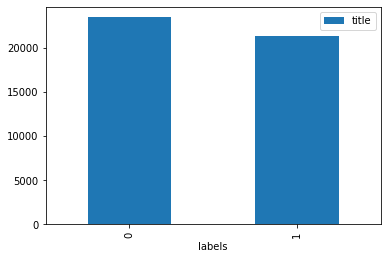

Fake news data: 23481
True news data: 21417


In [ ]:
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

# We use binary labels:
# 0: Fake
# 1: True
df_fake['labels'] = 0
df_true['labels'] = 1

df = pd.concat([df_fake, df_true])
df.groupby('labels').count().plot(kind='bar', y='title')
plt.show()
print(f'Fake news data: {len(df_fake)}')
print(f'True news data: {len(df_true)}')

# Balance the bias
The datasets current are slightly biased with nearly 10% more fake news than true news data points.  To ensure that the output is not skewed because of this imbalance, we will randomly sample.

To make the code more extensible for updates to the data points, we will take the minimum of either data sets, and fractional sample both.

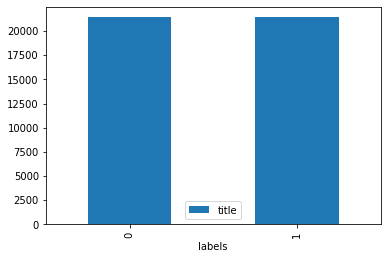

Fake news data: 21417
True news data: 21417


In [ ]:
n_samples = min(len(df_fake), len(df_true))

df_fake = df_fake.sample(n_samples)
df_true = df_true.sample(n_samples)

df = pd.concat([df_fake, df_true])
df.groupby('labels').count().plot(kind='bar', y='title')
plt.show()
print(f'Fake news data: {len(df_fake)}')
print(f'True news data: {len(df_true)}')

# For this training model, we ignore the effects of the title, subject, and date.  We only keep the text.

In [ ]:
df_fake = df_fake[['text', 'labels']]
df_true = df_true[['text', 'labels']]

# Create custom train / test split routines
We use our custom code for the train / test split as we want to evenly split
out the fake and true news portions rather than randomly selecting which
might reintroduce biases back to the model

In [ ]:
# Create custom train/test split
def split_train_test(df, test_portion=0.2):
  train_size = int(len(df) * (1-test_portion))
  df_train = df.iloc[:train_size,:]
  df_test = df.iloc[train_size:,:]

  return df_train, df_test


In [ ]:
df_fake_train, df_fake_test = split_train_test(df_fake)
df_true_train, df_true_test = split_train_test(df_true)

### Now we want to combine dataframes, and extract out the text and labels into lists that can be operated on as vectors

In [ ]:
# Training data
df_train = pd.concat([df_fake_train, df_true_train])
df_train = df_train.sample(frac=1).reset_index(drop=True)
x_train = list(df_train['text'])
y_train = df_train['labels'].to_numpy()

# Test data
df_test = pd.concat([df_fake_test, df_true_test])
df_test = df_test.sample(frac=1).reset_index(drop=True)
x_test = list(df_test['text'])
y_test = df_test['labels'].to_numpy()

In [ ]:
n = 10
for i in range(n):
  print(f'Label: {y_train[i]}')
  print(f'{x_train[i]}')
  print()

Label: 0
Facts are funny things Ever wonder why the Left is so opposed to using them in an argument?CNN law enforcement analyst Art Rodericktold explained to CNN host Brian Stelter, armed protesters in Oregon who took over a federal building to protest a tyrannical federal government, were not being surrounded by federal agents because:  They re not destroying property, they re not looting. 

Label: 1
WASHINGTON (Reuters) - Nevada Governor Brian Sandoval, a Republican and a former federal judge, is being considered by President Barack Obama for a possible appointment to the U.S. Supreme Court replacing the late Justice Antonin Scalia, a source close to the process said on Wednesday. The source, who asked not to be identified, said Sandoval met on Monday in the U.S. Capitol with Senate Democratic leader Harry Reid, at which time Reid asked the governor whether he would be interested in being considered for the high court job. “He said he was interested,” the source said, adding that “a 

# Define training and NLTK parameters in one place

In [ ]:
vocab_size = 5000
trunc_type = 'post'
padding_type = 'post'

# Token to be used for words outside of the vocab
oov_tok = '<OOV>'
pad_tok = '<PAD>'

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
print(f'Length of bag-of-words before stopword removal: {len(word_index)}')

Length of bag-of-words before stopword removal: 122388


In [ ]:
# Remove stopwords to improve accuracy
#for key in STOPWORDS:
#  word_index.pop(key, None)

print(f'Length of bag-of-words after stopword removal: {len(word_index)}')

# Create reverse index for lookup, and add a key for <PAD>
word_index_reverse = {v:k for k,v in word_index.items()}
word_index_reverse[0] = pad_tok

Length of bag-of-words after stopword removal: 122388


In [ ]:
print(dict(list(word_index.items())[:20]))
print(dict(list(word_index_reverse.items())[:20]))

{'<OOV>': 1, 'the': 2, 'to': 3, 'of': 4, 'a': 5, 'and': 6, 'in': 7, 'that': 8, 's': 9, 'on': 10, 'for': 11, 'is': 12, 'said': 13, 'he': 14, 'it': 15, 'trump': 16, 'with': 17, 'was': 18, 'as': 19, 'by': 20}
{1: '<OOV>', 2: 'the', 3: 'to', 4: 'of', 5: 'a', 6: 'and', 7: 'in', 8: 'that', 9: 's', 10: 'on', 11: 'for', 12: 'is', 13: 'said', 14: 'he', 15: 'it', 16: 'trump', 17: 'with', 18: 'was', 19: 'as', 20: 'by'}


# Convert the training and test text to sequences

In [ ]:
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
for i in range(5):
  print(train_sequences[i])
  print(test_sequences[i])

[1410, 29, 2767, 385, 421, 2198, 244, 2, 241, 12, 73, 1398, 3, 536, 96, 7, 31, 2471, 441, 125, 718, 2644, 3729, 1, 1783, 3, 441, 825, 2807, 1, 920, 847, 7, 2294, 30, 266, 69, 5, 176, 821, 3, 978, 5, 1, 176, 70, 48, 25, 113, 4830, 20, 176, 1195, 98, 32, 150, 25, 3874, 1544, 32, 150, 25, 1]
[15, 9, 2147, 3, 173, 2, 1040, 1, 17, 912, 913, 18, 69, 2, 1153, 14, 18, 997, 26, 21, 291, 19, 16, 9, 129, 121, 860, 33, 15, 9, 25, 2, 71, 2227, 6, 70, 667, 228, 22, 46, 1506, 913, 6, 21, 3614, 17, 148, 6, 32, 86, 364, 334, 3555, 1, 3175, 5, 59, 409, 103, 928, 7, 148, 878, 913, 3, 2017, 5, 1, 7, 662, 17, 195, 38, 1416, 539, 1247, 1, 1, 2, 2852, 396, 10, 2, 71, 2227, 228, 476, 1168, 8, 812, 2939, 1, 6, 673, 1373, 8, 3175, 1726, 878, 913, 608, 3696, 185, 3, 2017, 2, 3112, 6, 25, 316, 226, 1, 14, 18, 3439, 1, 16, 6, 21, 94, 7, 5, 1, 3003, 25, 108, 18, 14, 878, 5, 627, 1, 28, 2, 1, 33, 21, 487, 873, 618, 730, 581, 3216, 26, 8, 1, 57, 88, 913, 18, 878, 4734, 3216, 3, 1406, 17, 539, 6, 95, 212, 11, 91, 195,

# Before padding
We see that the sequences are all currently of different lengths.  We need to pad them so that the neural network receives a fixed-length vector

In [ ]:
for i in range(10):
  print(len(train_sequences[i]))

63
111
648
803
7
420
63
922
325
488


## Compute the largest vector length

In [ ]:
max_length = 0
for i in range(len(train_sequences)):
    if len(train_sequences[i]) > max_length:
        max_length = len(train_sequences[i])
        print(f'Swapped in loop {i}')

print(max_length)

Swapped in loop 0
Swapped in loop 1
Swapped in loop 2
Swapped in loop 3
Swapped in loop 7
Swapped in loop 12
Swapped in loop 32
Swapped in loop 44
Swapped in loop 53
Swapped in loop 216
Swapped in loop 2017
Swapped in loop 3411
Swapped in loop 3868
Swapped in loop 6569
8375


# After padding
The vectors are now padded to the max_length which was computed above based on the longest text string in the train data


In [ ]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
for i in range(10):
  print(len(train_padded[i]))

8375
8375
8375
8375
8375
8375
8375
8375
8375
8375


# Model definition

In [ ]:
# Training model hyperparameters
n_epochs = 20
learning_rate = 0.001
batch_size = 100

embedding_dim = 32


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=10, output_dim=4, input_length=10))
#model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
#model.add(Flatten())
#model.add(Dense(10, activation='relu'))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 4)             40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
pred = model.predict([[0,1,2,3,4,5,6,7,8,9]])

In [ ]:
print(pred)
print(pred.shape)

[[[ 0.00688154  0.00261034 -0.02349842 -0.00556986]
  [-0.02238644  0.00348651  0.03742358  0.01403463]
  [ 0.0394017   0.01898955  0.01731303 -0.01084424]
  [ 0.04710582  0.0280589  -0.0279382  -0.04725216]
  [ 0.04576485 -0.0148319  -0.04730991  0.00661497]
  [ 0.00018726 -0.00565823  0.02269596  0.00646261]
  [ 0.01726318  0.01803002 -0.0107354   0.02789522]
  [ 0.00832355  0.00630401  0.02860614  0.00487331]
  [-0.02008404  0.01651489 -0.02495884  0.01606791]
  [-0.03660799 -0.01431718 -0.03340808 -0.03138625]]]
(1, 10, 4)


In [ ]:
for i in range(10):
    print(y_train[i])
    print(train_padded[i])
    print()

0
[1410   29 2767 ...    0    0    0]

1
[ 106   66 2650 ...    0    0    0]

0
[  2 171   7 ...   0   0   0]

1
[   1  500 2075 ...    0    0    0]

0
[ 551 2692 1158 ...    0    0    0]

1
[66 38 72 ...  0  0  0]

0
[  15 1421   93 ...    0    0    0]

1
[ 1 66 34 ...  0  0  0]

1
[106  66  77 ...   0   0   0]

0
[4006   10    2 ...    0    0    0]



In [ ]:
history = model.fit(train_padded, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(test_padded, y_test), verbose=1)

Train on 34266 samples, validate on 8568 samples
Epoch 1/20
34266/34266 [==============================] - 35s 1ms/sample - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 2/20
34266/34266 [==============================] - 34s 979us/sample - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 3/20
34266/34266 [==============================] - 33s 975us/sample - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 4/20
34266/34266 [==============================] - 33s 978us/sample - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 5/20
34266/34266 [==============================] - 34s 982us/sample - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 6/20
34266/34266 [==============================] - 34s 986us/sample - loss: 7.6246 - accuracy: 0.5000 - val_loss: 7.6246 - val_accuracy: 0.5000
Epoch 7/20
34266/34266 [=======================

KeyboardInterrupt: 